## Write-ups

### Section 1: Overview.

In this project, I built a pulse oximetry capable of measuring blood oxygen saturation (SpO2) and heat rate (HPM).

The device is based on hardware where there's are LED light sources that shines through your finger or the chosen body part. On the other side, a sensor detects how much of that light successfully passes through. Different parts of your tissue, veins, and arteries absorb light in different ways. However, what's most important is that the blood in your arteries pulsates with your heartbeat, causing variations in how much light gets absorbed.

As your heart beats, blood volume in your arteries increases and decreases periodically, changing how much infrared light the sensor detects. The sensor picks up this changes, plotting the light strength over time. From the data, I will be developing an algorithm that identifies its period, and count how many heart beats per minutes by this. I will be explaining the algorithm later in detail.

Besides tracking your pulse rate, the device also checks how well your blood carries oxygen. Blood that carries oxygen absorbs light differently from blood that doesn't. The device uses a second, visible wavelength of light in addition to infrared. By comparing the absorption of these two wavelengths, the pulse oximeter can estimate your blood oxygen saturation, which represents the proportion of oxygen-carrying hemoglobin compared to the total amount in your bloodstream. Still we obtain the data of red and IR light strength over time, and extract their AC and DC component. And the blood situation is fitted by the formula below:

$$ \begin{align}
R \approx \frac{\left. \mathrm{AC}_1 \middle/ \mathrm{DC}_1\right.}{\left. \mathrm{AC}_2 \middle/ \mathrm{DC}_2\right.}.
\end{align} $$

$$\mathrm{SpO_2} = aR^2 + bR + c$$ where a = -3.3, b = -21.1, c = 109.6.

The AC and DC component can be obtained from the data with a peak detection algorithm and a DC filter, which I can reuse directly form my algorithms in detecting the pulse period. I will explain this in detail in the later section.

The results of HPM and SpO2 are presented to the user on the screen. And the user may also checkout the raw heart beat waveform (light variation overtime curve).

The physical hardware (including the light sources and detector, as well as the mechanical part that attach it to your hand to obtain an accurate measurement) comes as a prebuilt model. All the data collection (sampling) and processing described above are done via a simple circuit and a Arduino Uno board. Thus, I target to make this work as a standalone device, without the need for external computing power.


### Section 2: Design and design considerations.

#### Circuit

The circuit serve the purpose of both controlling the two leds, as well as capturing the light intensity by a photodiode. The ir and red LEDs are already connected in parallel in a opposite pole built in to the sensor probe clip. What we need is to connect a small resisors limiting the current and prevent the LEDs from breaking down. 

And this component is connected to two digital output pins of the Arduino. Setting one to high and one to low at a time allows us to set the direction of current, thus letting either one of the led to be on at a time. 

![](https://be189.github.io/_images/pulseox_sensor.png) 

The photodiode is a current source. To measure its current (which is porpotional to the light intensity we want to measure), I connect it in a transimpedance style circuit, turning the current into measurable voltage by Arduino DAC through a OpAmp and a 330kΩ resistor (this value is chosen according to the probe clipper datasheet, providing the right among of amplification to get the best dynamic range).

#### Schematics

![schematics](schematics.svg)

#### Breadboard

![breadboard](breadboard.jpg)

#### Sampling

Obtaining the IR and red light intensity is tricky for such device, as there's only one detector (photodiode), and two light sources (red and IR LED). Thus we need fine-grind control of the on and off of the two leds and sample time. I desgined the stragegy as shown below.

![sampling](sampling.png)

In the arduino sketch, I set up a periodic timer interrupt, which sample the current wavelength voltage readout using the built-in ADC, save it to the corresponding global variable. Then, it perform a current direction switch, turning on the right LED of the next inturrpt. It switch between the two LEDs, but there's only a single interrupt, launched at twice the rate of target sample rate, which use if statement to determine which LED to sample or switch to. Detail of the implementation please refers to *ISR(TIMER1_COMPA_vect)* in the Arduino sktech in the code section below.

A timestamp in ms is attached with each sample, making it easier for other task to identify whether a new sample is obtained; The design choice of launching the sampling task as timer interrupt isolates it from the influence of other processing tasks (espically the main processing task gets overloaded), avoiding distortion and ensure time accuracy of the most critical signal. 

Notice the peak detection and SpO2 calculation does not required any specific units or scale, so the value recorded is directly the ADC readout (0-1023 range), which out any further linear conversion to voltage or light intensity.

The captured data could be streamed to PC (and saved as .csv), allowing easier visualization and help building the python prototype of the filtering and peak detection algorithms.

#### Displaying Wave

The pulse oximetry should also allow users to visualize the raw pulse waveform. However, the LCD used (LCD1602) operates strictly in text mode and does not support control over individual pixels. To effectively utilize the LCD's resolution and achieve a higher-definition waveform, I leveraged the LCD's capability to define 8 custom characters dynamically. Specifically, a mechanism was developed to store and continually update a software framebuffer, dynamically writing segments near the waveform's leading edge into these custom characters. The waveform is displayed in a continuously rolling manner, updating from left to right and wrapping around. Given the limit of 8 custom characters, only a small portion (4 columns × 2 lines) can be displayed simultaneously. To extend the visible waveform, I exploited the slow pixel-response time inherent in the LCD. By alternately updating every other column, the pixels from previously updated columns linger briefly, creating an optical persistence effect. This effectively doubles the visible waveform length, allowing 8 columns to appear simultaneously on the display. Here's a visualization of the algorithm.
![wave_method](wave_method.png)
Implemented in *lcd_frame_buffer.h* and *display_task()* in *firmware.ino*.

The filtering and pulse detection are also key functions in the design. They are explained in detail in **Section 5: Data Analysis**

### Section 3: User Manual

The device runs in fully standalone mode: Once you power it up, and put one of your fingers (perferably index, middle and ring finger on either hands) to the probe, it starts displaying SpO2 (unit: %) and heart rate (HPM) on the LCD.
![display_stats](display_stats.jpg)
On the left side of the screen, there's a emoji that tells you your current health status, whether the SpO2 is too low, or heart rate is too fast. The list of health status and corresponding emojis are:
```
HEALTHY  HIGH_HPM  VERY_HIGH_HPM  LOW_SPO2  CRITICAL_SPO2   DEAD    UNKNOWN          
  ^_^      o_o          @_@          -_.`        -_-         x_x      ?_? 
  / |      /u>          /3!          / |         /!|         /!|      /*|
```
No calibration is needed to use this device. After putting your finger to the probe, allows the detector for ~4 seconds to settle to a relatively stable value to get a accurate measurement. Make sure not to move your hands when you want an accurate measurement.

**Displaying the Pulse Wave**

To display the raw pulse wave, press the button on the breadboard. It switch between displaying the stats (HPM and SpO2) and the pulse wave display mode.
![button](button.jpg)

Once your are in that mode, you can see the wave displaying on the screen in a rolling fashion. The operation is rather simple with no other interface.
![display_wave](display_wave.jpg)

The resolution of the screen is low. If you want a better display of it, or want to save the pulse data for further investigation, you can use the *steaming.ipynb* notebook in this folder. The device streams the data to computer by default, and you can save it as .csv files in notebook.


### Section 4: Demo + Assessment

#### Video

My heart rate was pretty high (110-120 hpm) during the demo .

<video width="600" controls>
  <source src="demo.mp4">
</video>

#### Qualitative Verification

The robustness is tested by using different fingers, inducing changes to my heart rate, using it in different lighting environment, and changing skin tone (by washing hand or adding a small piece of film to my finger). I verify that the HPM works normally and pretty accurately compared with the result of Apple Watch. But the SpO2 is always off by 5 - 20, and don't really respond so well to the change in actual SpO2 level.

#### Quantitative Assessment

As there are not ground truth value for comparison, I 

Average HPM: 109.53454617869257, Standard Deviation: 2.497460653886708


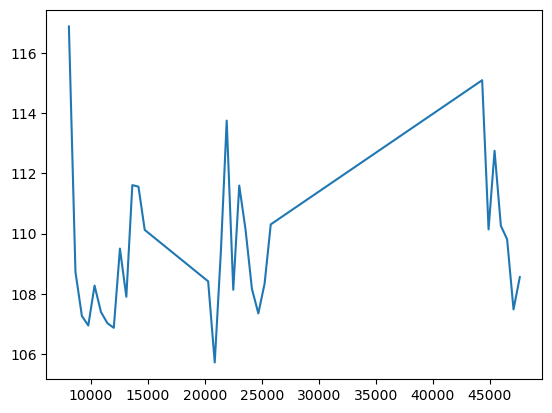

In [224]:
calculate_stats(hpms_red, t = red_results[0], bounds = [region0, region1, region3], plot = True, data_name = "HPM")


Average SpO2: 86.06964016058015, Standard Deviation: 2.6174342942109248


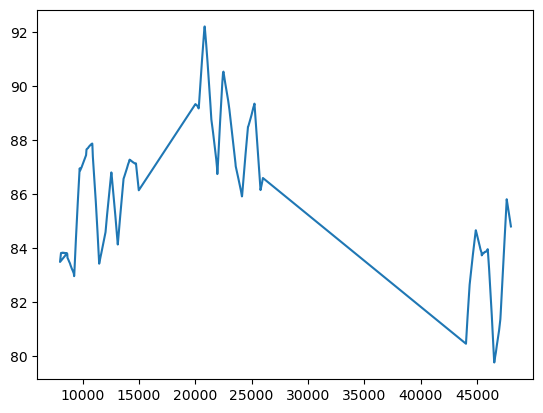

In [218]:

calculate_stats(spo2, t = t_raw, bounds = [region0, region1, region3], plot = True, data_name = "SpO2")

### Section 5: Data Analysis 

#### Filtering

Two filters are used for the purpose of this pulse oximetry:
- Low pass filter.

Use to remove the noise from the samples. I use a simple first-order butterworth IIR filter for the embedded system, which only involves one history buffer and two floating point multiplication for one sample. The cut-off frequency is set to be at $F_c = 6Hz$, which is a margin higher than human heart rate frequency to remove all possible noise while retaining enough frequency information to calculate heartbeat. The first-order butterworth filter is given by the following time-domain equation



$$y[n] = c_{f1} \cdot y[n-1] + c_{f0} \cdot x[n] + c_{f0} \cdot x[n-1]$$

where (calculated from the $F_c = 6Hz$ (cutoff frequency) and sampling frequency of $F_s = 80Hz$): 
$$c_{f0} = 0.16591068104, \quad
c_{f1} = 0.6681786379193$$

- DC remover. The light intensity might change due to different ambient lighting or skin tones. When we care is only the relative change in a short time window to identify its period. So a DC remover is applied to normalize the moving average to around 0. Still, we applies a IIR-style DC component filter.
$$
\begin{aligned}
w[n] &= x[n] + \alpha\,w[n-1], \\
y[n] &= w[n] - w[n-1]. \\
DC[n] &= (1-\alpha)w[n]
\end{aligned}
$$

The choice of $\alpha$ trades off between slower response (larger $\alpha$) and more unstable to sudden changes (smaller $\alpha$) After some experiments, I set $\alpha = 0.96$.

This DC filter provides the DC value of light intensity, providing the essential piece information to calculate SpO2.

The filtering are all digital-based, implemented with c++ on arduino, and done inside the sampling interrupt handler to allow full utilization of the raw sampling rate. Detailed implementation in *filters.h*


#### Period Calculation & Peak (Heart Beat) Detection

To obtain the pulse period, we can identify the peaks of the pulse wave, and calculate the time difference between each peak. Due to the limitation of Arduino, keeping a long history buffer of the wave is not possible. Therefore, I design a efficient, state-machine based approach optimized for real-time peak detections.

![states](states.png)

One key value of is the Threshold, which adaptively keep track of the expected value boundary for the state change.
The states include:
- WAITING: when initialized or has finished one detection cycle, decrease the Threshold. The correspond to the downstroke phase of a heart beat.
- UPWARD: When the value gets above the threshold, and the curve slope is greator than a threshold, enter this face. Correspond to the upstroke of heart beat. The Threshold follows the maximium value it has seen so far. Once the value drops a certain margin below the threshold, the upstroke is done, a peak is detected.
- MASKED: affter a beat detected, assume another beat would not happen for a certain period. Restart the cycle (to WAITING state) once the mask timeout has passed. The thershold is also dropping in this state as it is likely to be the downstroke.

The rate of drop of threshold is adapted according to the previous period recorded. It is also controlled by an extra cofficient which we could tune.

Once a Peak is detected, the timestamp is recorded, and time lapse between last peak is calculated. The period is further stablized using a simple first-order IIR filter. Setting the alpha also means the tradeoff between less stablized heart rate or longer delay. 

Notice when the finger is not in the probe clip, no vibration of light intensity would be detected. Due to the DC filter, the value would drop to zero. As the Threshold has a minimium ceiling > 0 (would not further decrease). In this case, the value would never gets beyond Threshold, and never enter the upward state, no pulse will be detected. If no pulse is detected for more than 2 seconds, the device assumes no heart beat is detected, and display a value of NaN. This mechanism cleverly identifies the scenario when no finger is present, and avoid outputing garbage.

The state machine system itself is inspired by an open source project for another [oximetry module](https://github.com/oxullo/Arduino-MAX30100/blob/master/src/MAX30100_BeatDetector.cpp). With two major modification to adpat for my system and hardware:
- The DC filter generates a large spike when the light changes suddenly (usually when putting on or taking off the probe clip). So when the value is way too large, I will ditch the current state and recorded period and forceably reset to WAITING state. This helps restart a new detection cycle and settle to new readings swiftly.
- The original design have five states, but I identify the states that are redundant and could be handled as one state. The states of UPWARD and MAYBE_DETECTED (my implementation still seperate these two states, but they are basically the same thing), and the states of INIT and WAITING are merged, making the transition diagram cleaner.

The filtering and state machine algorithm is first prototyped with python, and experiemented on the collected .csv dataset. This helps me verify the algorithm, and tune the parameters. In the python code section below, I create a visualization of the this algorithm in action. The yellow line is the Threshold, the large red dot is the peak, and the small grey, orange and black dots on the value curve represent the states at that timestamp. 
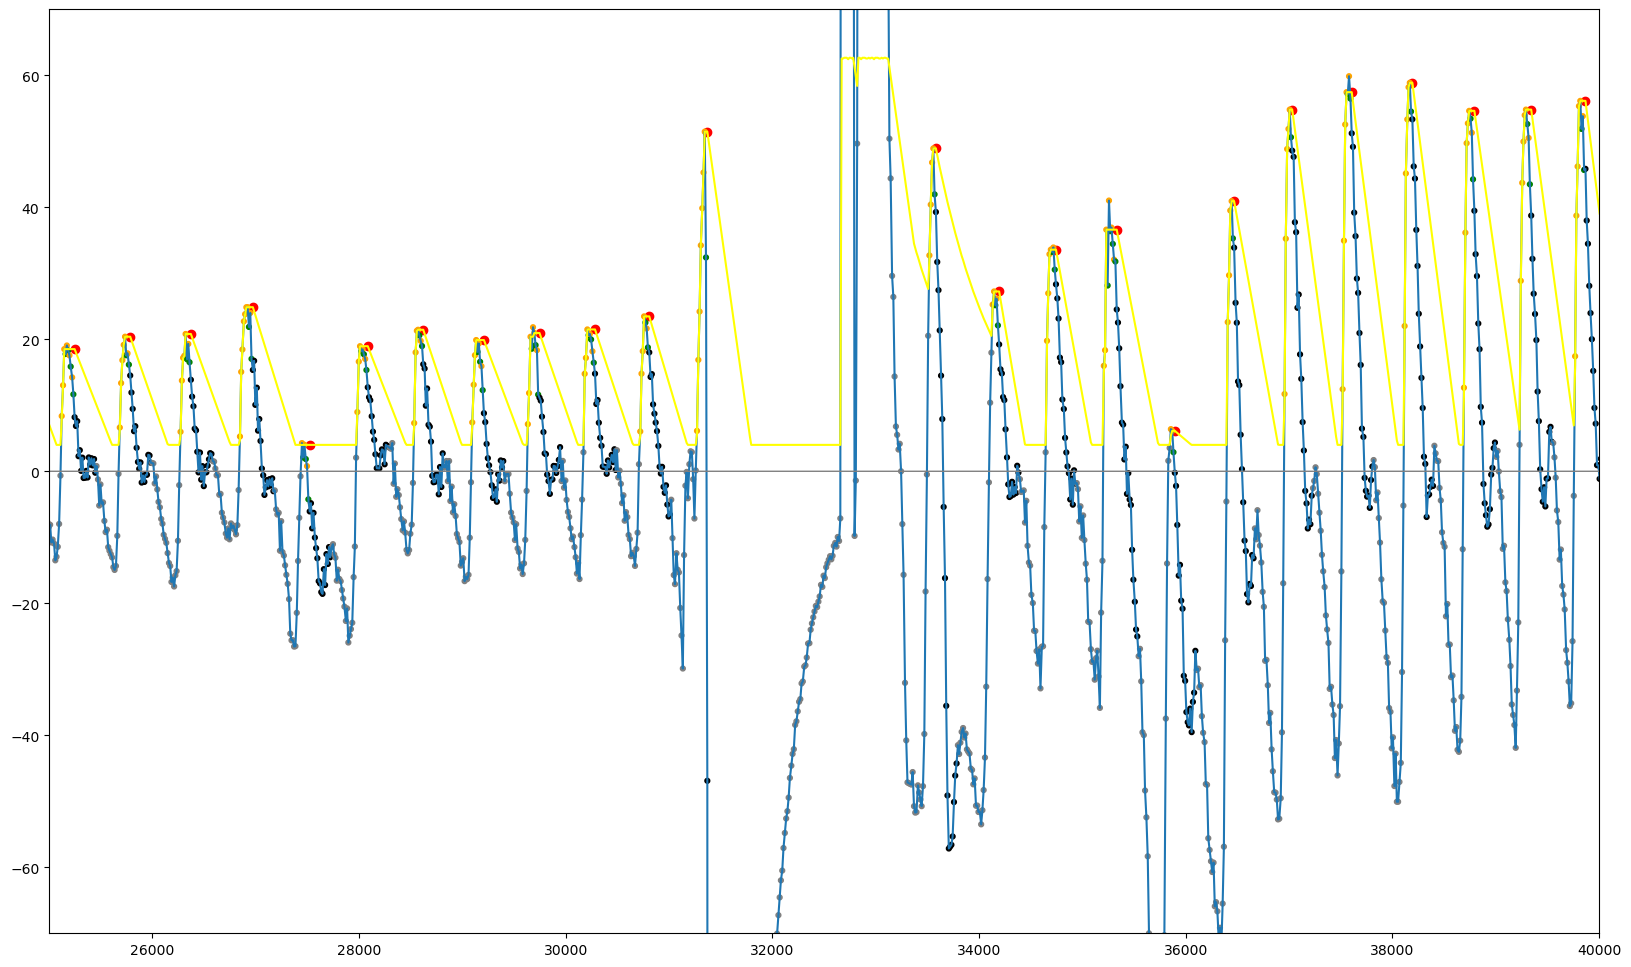
I also include the code that add bias, distortion (compress or expand in time), or random noise, to validate its robustness under complex scenarios. You my try stacking all these factor in *Adding bias/distortions* block in the python code section, and verifies that this still works.
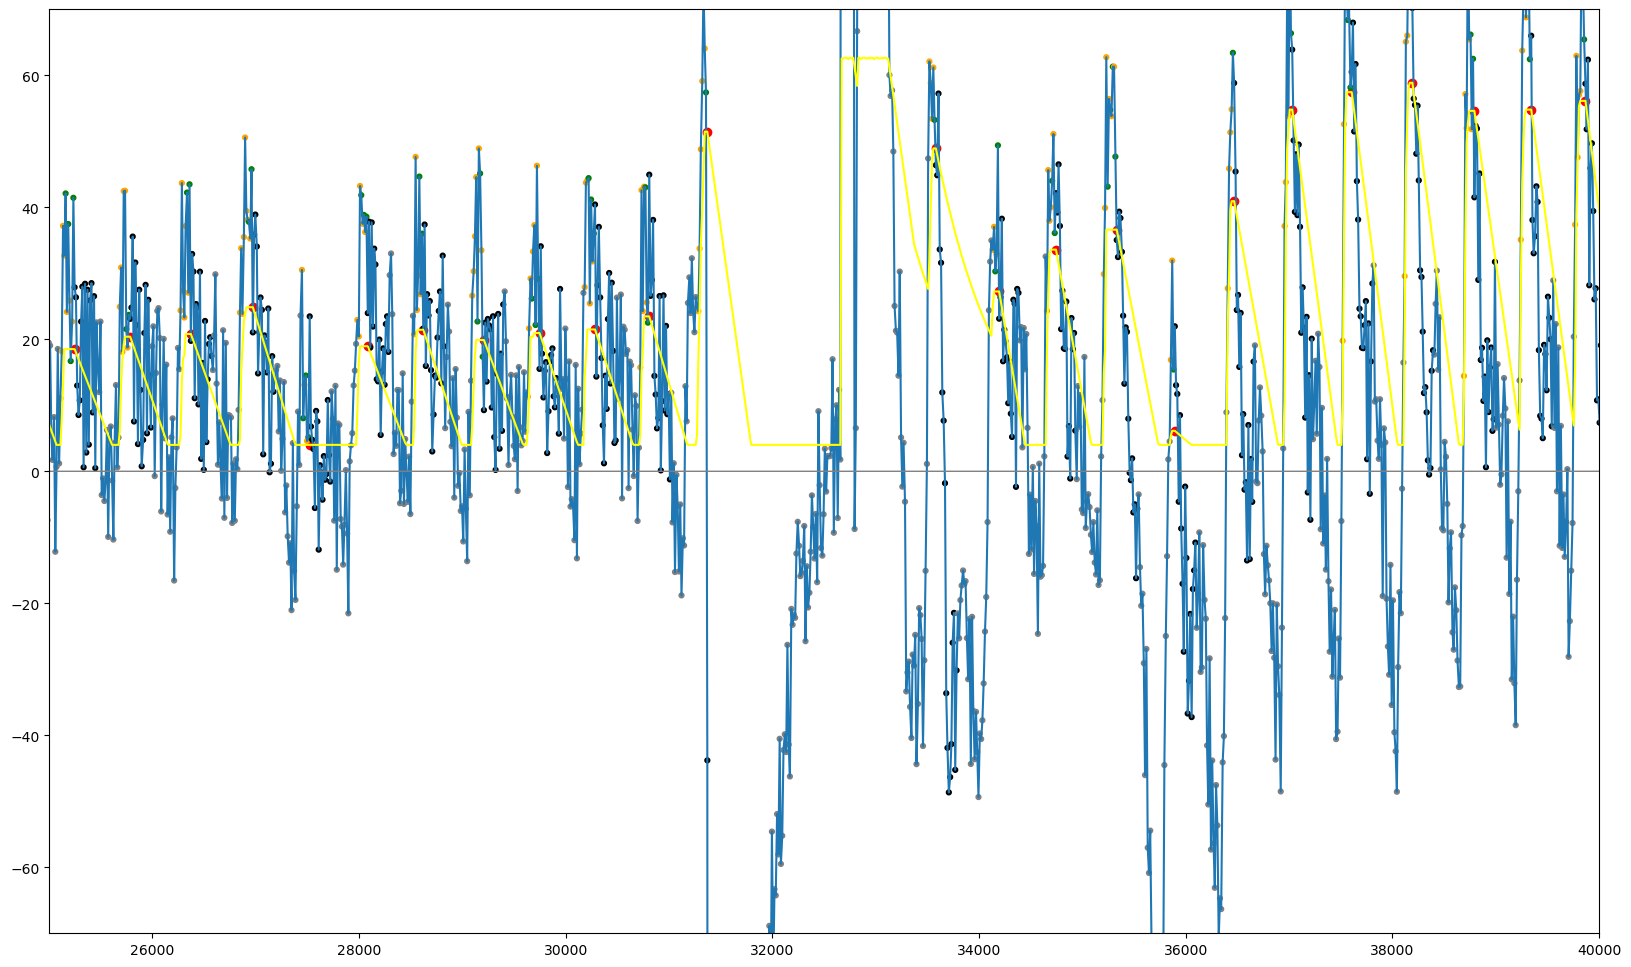

The python prototype is directly ported to Arduino without major change. Some optimzation such as precompute/buffer floating point values to reduce the number of slow multiplications are used to improve efficiency. Details of the implementation could be found in *beat_detector.h* in the Arduino code section. The result from the IR instead of red is used for this algorithm in the end, as its amplitude is usally larger thus less prone to noises.


#### Blood Oxygen Saturation (SpO2) calculation

The AC value of a pulse wave is its amplitude (value of the peak), and it happens to be Threshold when a beat is detected. This value is recorded for both the IR and Red sensor when calculating their period, and together with the DC value obtained in DC filter, are fed to the equations together mentioned in the Overview section, to obtain a a SpO2.

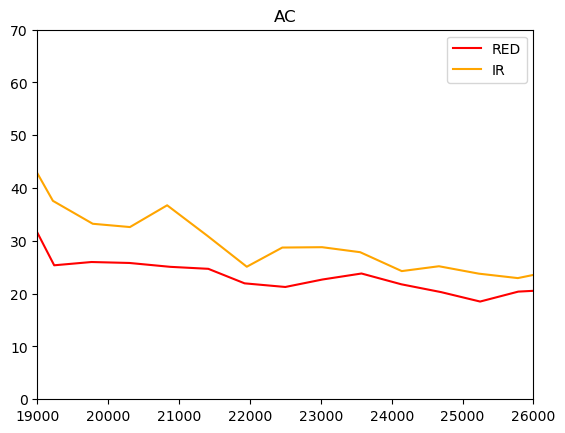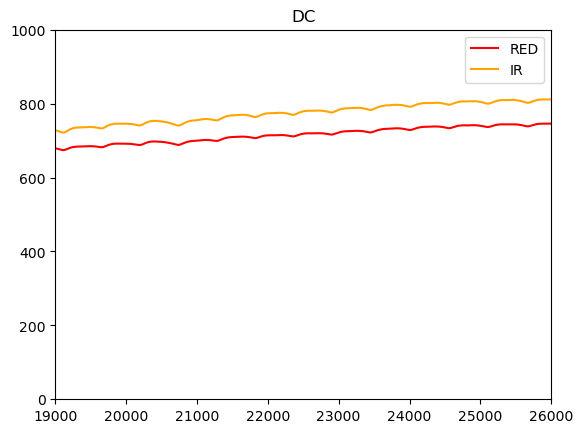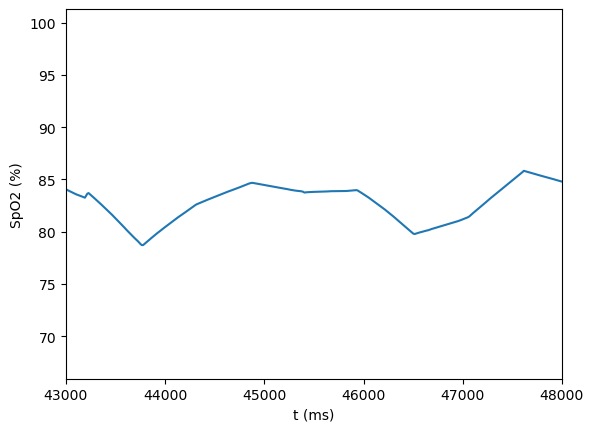

### Section 6: Suggestions for future improvements

- Due to the trade off, sometimes the user might want a faster reponse of HPM, or sometimes wants a more stable and accurate value. I could add a button that support switching between the "fast mode" and "slow mode" for HPM reading. It modify alpha filtering constant of the pulse period underneath.
- No hardware filter are used right now. Might want to add one to make it more robust when the power supply source is not stable, making the data smoother and more accurate. 
- Right now the SpO2 is calculated with the formula and constant in the Tremper and Barker paper. Might better calibrate it with my devices, by collecting waveform data and the corresponding SpO2 to find a better fit.
- Much information could be extracted from the pulse wave, inlcuding identifying potiential cardiac diseases such as arrhythmias. Could add functionalities of giving diagonsis to patients to make better use of the hardware.

## Code

###  Arduino Sketch

#### firmware.ino (main)

```c
#include <util/atomic.h>
#include "filters.h"
#include "types.h"
// #include "lcd.h"
#include "lcd_frame_buffer.h"
#include "beat_detector.h"
#include <LiquidCrystal_I2C.h>

#define FLOAT_INVALID -0.123456
#define RED   0
#define IR    1


const bool inverted = true;
const int analog_max = 1023;

// pins
const int sample_pin = A0;
const int red_led_pin = 7;
const int ir_led_pin = 6;

// constant for sampling
const uint8_t prescaler = 64;
const uint16_t base_sample_f = 80;
const uint8_t red_divider = 1;
const uint8_t ir_divider = 1;
uint8_t dividers[2] = {red_divider, ir_divider};
const float CPU_F = 16e6;


// global variables for ISR
const int isr_count_reset = red_divider * ir_divider * 2;
uint16_t isr_count = 0;
// global variables for loop
uint32_t last_red_sample_time  = 0;
uint32_t last_ir_sample_time  = 0;
sample_t ir_local, red_local;

// shared buffer sampling timer isr and loop
volatile sample_t ir_sample, red_sample;

// filter classes
DCFilter red_dc_filter(0.96);
DCFilter ir_dc_filter(0.96);
butterWorthLPF red_lpf(6, 80);
butterWorthLPF ir_lpf(6, 80);

// beat detectors
beatDetector ir_beat_detector;
beatDetector red_beat_detector;

//buttons 
const uint16_t debouncingDelay = 300;
uint32_t last_button_time = 0;
const uint8_t ALL_BUTTONS = (1<<PD2) | (1<<PD3);
const uint8_t DISPLAY_MODE_BUTTON = 1<<PD2;
const uint8_t PERIOD_MODE_BUTTON = 1<<PD3;
bool prev_button_pressed = false;

//states
#define WAVE_MODE 0
#define STATS_MODE 1
uint8_t display_mode = STATS_MODE;

// lcd params
int8_t refresh_x_offsets[4] = {0, -2, -4, -6};
lcdFramebuffer frame_buffer(PXIEL_STANDARD_MODE, PXIEL_STANDARD_MODE);
const uint8_t LCD_ADDR = 0x27;
LiquidCrystal_I2C lcd = LiquidCrystal_I2C(LCD_ADDR, NROWS, NCOLS);
const uint8_t screen_width = frame_buffer.get_screen_width();
const uint8_t screen_height = 16;

// variables for display task
uint8_t last_write_y = 0;
uint8_t wave_frontier_x = 0;
const int8_t    max_wave_amplitude = 12;
const uint16_t  wave_display_period = 1000/screen_width;
const uint16_t stats_display_period = 20;
uint32_t last_display_update = 0;
uint16_t  last_display_period = -1;
uint16_t  current_bpm = 0xffff;
//spo2
const float spo2_a = -3.3;
const float spo2_b = -21.1;
const float spo2_c = 109.6;
float last_AC1, last_AC2;
// health status
#define HEALTH_HEALTHY          0
#define HEALTH_HIGH_HPM         1
#define HEALTH_VERY_HIGH_HPM    2
#define HEALTH_LOW_SPO2         3
#define HEALTH_CRITICAL_SPO2    4
#define HEALTH_DEAD             5
#define HEALTH_UNKNOWN          6
String health_line0[] = {"^_^ ",  "o_o ", "@_@ ", "-_.`", "-_- ",  "x_x ", "?_? "};
String health_line1[] = {"/ |",   "/u>",  "/3!",  "/ |",  "/!|",   "/!|",  "/*|"};

inline void sample(sample_t& sample) {
  int sample_v = analogRead(sample_pin);

  if (inverted)
    sample_v = analog_max - sample_v;

  sample.v  = static_cast<float>(sample_v);
  sample.t = millis();
}

inline void switching(uint8_t led) {
  if (led == RED) {
    digitalWrite(red_led_pin, HIGH);
    digitalWrite(ir_led_pin, LOW);
  } else if (led == IR) {
    digitalWrite(ir_led_pin, HIGH);
    digitalWrite(red_led_pin, LOW);
  }
}

inline void filter(sample_t& sample, DCFilter& dc_filter, butterWorthLPF& lpf) {
  float v_temp = lpf.step(sample.v);
  sample.v = dc_filter.step(v_temp);
//  Serial.print("\n in filter v ");
//  Serial.println(sample.v);
  sample.dc = dc_filter.get_dc();
}


// sampling ISR
ISR(TIMER1_COMPA_vect) {
  uint8_t sampling_led = isr_count%2;
  uint8_t switching_led = (isr_count+1)%2;
  int   sample_count = isr_count/2;
  int   switch_count = (isr_count+1)/2;

  sample_t new_sample;
  if (sample_count % dividers[sampling_led] == 0) {
    sample(new_sample);
  }
  if (switch_count % dividers[switching_led] == 0) {
    switching(switching_led);
  }
  
  if (sample_count % dividers[sampling_led] == 0) {
    if (sampling_led == RED) {
      filter(new_sample, red_dc_filter, red_lpf);
      red_sample = new_sample;
    }
    else if (sampling_led == IR) {
       filter(new_sample, ir_dc_filter, ir_lpf);
       ir_sample = new_sample;
    }
  }
  
  isr_count += 1;
  if (isr_count == isr_count_reset) 
    isr_count = 0;
}

void draw_health_status(uint8_t status) {
  lcd.setCursor(12, 0);
  lcd.print(health_line0[status]);
  lcd.setCursor(12, 1);
  lcd.print(health_line1[status]);
}

void display_task(sample_t& sample, beatDetector& beat_detector) {
  if (display_mode == WAVE_MODE) {
  // display the pulse wave with lcd frame buffer class
    if (sample.t > last_display_update + wave_display_period) {
      last_display_update = sample.t;

      int16_t v_corrected = static_cast<int16_t>(sample.v) + max_wave_amplitude;
      if (v_corrected < 0)
        v_corrected = 0;
      if (v_corrected > max_wave_amplitude*2-1)
        v_corrected = max_wave_amplitude*2-1;
      v_corrected = v_corrected * 16 / (max_wave_amplitude * 2);
      uint8_t write_y = 15 - v_corrected % 16; 

      getCellReturn_t coord;
      frame_buffer.get_cell(coord, wave_frontier_x, last_write_y);
      frame_buffer.set_pixel(coord);
      if (write_y > last_write_y)
        for (uint8_t y = last_write_y+1; y<=write_y; ++y) {
          frame_buffer.get_cell(coord, 0xFF, y);
          frame_buffer.set_pixel(coord);
        }

      if (write_y < last_write_y)
        for (uint8_t y = last_write_y-1; y>write_y; --y) {
          frame_buffer.get_cell(coord, 0xFF, y);
          frame_buffer.set_pixel(coord);
        }

      last_write_y = write_y;

      if (coord.pixel_x == 4) {
        uint8_t next_cell_x = (coord.cell_x+1)%NCOLS;
        frame_buffer.clear_cell_in_pixel_buffer(next_cell_x, 0);
        frame_buffer.clear_cell_in_pixel_buffer(next_cell_x, 1);
      }
      
      if (coord.pixel_x >= 0 && coord.pixel_x < 4) {
        // would need to refresh the screen
        // frame_buffer.reset_character_buffer();
        int8_t cell_x = ((int8_t)(coord.cell_x) + NCOLS + refresh_x_offsets[coord.pixel_x])%NCOLS;
        int8_t old_cell_x = ((int8_t)(coord.cell_x) + NCOLS + refresh_x_offsets[coord.pixel_x] - 1)%NCOLS;
        frame_buffer.move_idx(lcd, old_cell_x, 0, cell_x, 0, coord.pixel_x*2);
        frame_buffer.move_idx(lcd, old_cell_x, 1, cell_x, 1, coord.pixel_x*2+1);
      }

      wave_frontier_x++;
      if (wave_frontier_x > screen_width)
        wave_frontier_x = 0;
    }
  }

  else if (display_mode == STATS_MODE) {
  // display heart rate
    if (sample.t > last_display_update + stats_display_period ) {
      last_display_update = sample.t;
      
      if (last_display_period != static_cast<uint16_t>(beat_detector.period)) {
        last_display_period = static_cast<uint16_t>(beat_detector.period);
        lcd.setCursor(5, 0);
        if (beat_detector.period > 60) {
          current_bpm = static_cast<uint16_t>(60000.0/beat_detector.period);
          // bpm_valid = true;
          if (current_bpm < 100) lcd.write(' ');
          lcd.print(String(current_bpm));
        } else {
          current_bpm = 0xffff;
          lcd.print("NaN");
          lcd.setCursor(5, 1);
          lcd.print("      ");
          draw_health_status(HEALTH_UNKNOWN);
        }
      }

      lcd.setCursor(4, 0);
      if ((beat_detector.state == STATE_UPWARD) || (beat_detector.state == STATE_PENDING_DETECTION))
        lcd.write('o');
      else
        lcd.write('@');
    }
  }

}


void spo2_calculate_display_task(float AC1, float DC1, float AC2, float DC2) {
  lcd.setCursor(5, 1);

  if ((last_AC1 != AC1 || last_AC2 != AC2) && (AC1 > 0) && (AC2 > 0) 
      && current_bpm!=0xffff && display_mode == STATS_MODE) {

    float R = ((last_AC1 + AC1)/2/DC1)/((last_AC2 + AC2)/2/DC2);
    float SpO2 = (spo2_a*R*R + spo2_b*R + spo2_c);
    
    if (SpO2 > 99.9) SpO2 = 99.9;
    if (SpO2 < 75.0) SpO2 = 75.0;
    lcd.print(String(SpO2, 1) + "%  ");

    uint8_t health_status;
    if (current_bpm > 128)  
      health_status = HEALTH_VERY_HIGH_HPM;
    if (current_bpm < 40 || SpO2<80)  
      health_status = HEALTH_DEAD;
    else if (SpO2 < 85)  
      health_status = HEALTH_CRITICAL_SPO2;
    else if (current_bpm > 108)  
      health_status = HEALTH_HIGH_HPM;
    else if (SpO2 < 92)  
      health_status = HEALTH_LOW_SPO2;
    else
      health_status = HEALTH_HEALTHY;
    
    draw_health_status(health_status);
    
    last_AC1 = AC1;
    last_AC2 = AC2;
  }

}

void serial_publish_task(bool publish_t_dc = false, float extra_value = FLOAT_INVALID) {
  if (extra_value != FLOAT_INVALID) {
    Serial.print(extra_value);
    Serial.print(',');
  }

  if (publish_t_dc) {
    Serial.print(red_local.t);
    Serial.print(',');
    Serial.print(red_local.dc);
    Serial.print(',');
  }
  
  Serial.print(red_local.v);
  Serial.print(',');

  if (publish_t_dc) {
    Serial.print(ir_local.t);
    Serial.print(',');
    Serial.print(ir_local.dc);
    Serial.print(',');
  }
  Serial.println(ir_local.v);
}

void set_stats_ui_background() {
  lcd.setCursor(0, 0);
  lcd.print("BPM             ");
  lcd.setCursor(0, 1);
  lcd.print("SpO2            ");
}

void button_service_task() {
  uint32_t currTime = millis();
  uint8_t buttons_pind = ~PIND;
  bool current_button = buttons_pind & ALL_BUTTONS;

  if ((!prev_button_pressed) && current_button && (currTime - last_button_time > debouncingDelay)) {
    
    if (buttons_pind & DISPLAY_MODE_BUTTON) {
      if (display_mode == WAVE_MODE)  {
        set_stats_ui_background();
        display_mode = STATS_MODE;
      }
      else if (display_mode == STATS_MODE) {
        wave_frontier_x = 0;
        display_mode = WAVE_MODE;
      }
    }

    last_button_time = currTime;
  }

  prev_button_pressed = current_button;
}


void setup() {
  Serial.begin(115200);
  
  float ocr1a_f = CPU_F / prescaler / base_sample_f / 2 - 1;

  pinMode(red_led_pin, OUTPUT); 
  pinMode(ir_led_pin, OUTPUT); 
  
  DDRD &= ~ALL_BUTTONS;
  PORTD |= ALL_BUTTONS;       // set button pins to input-pullup

  // put your setup code here, to run once:
  noInterrupts();           // Disable interrupts during config

  TCCR1A = 0;               // Clear control register A
  TCCR1B = 0;               // Clear control register B
  TCNT1  = 0;               // Initialize counter value

  OCR1A = (uint16_t)ocr1a_f;              // Compare match value (zero-indexed)

  // CTC mode (Clear Timer on Compare Match)
  TCCR1B |= (1 << WGM12);

  // Prescaler 64
  TCCR1B |= (1 << CS11) | (1 << CS10);

  // Enable Timer1 Compare Match A interrupt
  TIMSK1 |= (1 << OCIE1A);

  interrupts();             // Enable interrupts
  
  Wire.setClock(400000);
  // Initialize the LCD
  lcd.init();
  lcd.backlight();
  set_stats_ui_background();
  
  health_line0[HEALTH_HIGH_HPM][3] = 0b11011110;
  health_line0[HEALTH_VERY_HIGH_HPM][3] = 0b11011111;
}

void loop() {
  // put your main code here, to run repeatedly:
  ATOMIC_BLOCK(ATOMIC_RESTORESTATE) {
    red_local.t = red_sample.t;
    red_local.dc = red_sample.dc;
    red_local.v = red_sample.v;
    ir_local.t = ir_sample.t;
    ir_local.dc = ir_sample.dc;
    ir_local.v = ir_sample.v;
  }

  bool red_update = false;
  bool ir_update = false;

  if (red_local.t != last_red_sample_time) {
    red_update = true;
    last_red_sample_time = red_local.t;
  }

  if (ir_local.t != last_ir_sample_time) {
    ir_update = true;
    last_ir_sample_time = ir_local.t;
  }

  if (ir_update) {
    ir_beat_detector.step(ir_local);
    display_task(ir_local, ir_beat_detector);
  }

  if (red_update) 
    red_beat_detector.step(red_local);

  if (red_update || ir_update) {    
    spo2_calculate_display_task(red_beat_detector.v_last_peak, red_local.dc, ir_beat_detector.v_last_peak, ir_local.dc);
    serial_publish_task(false, ir_beat_detector.threshold);
  }

  button_service_task();
  
}
```

#### types.h

```c
#ifndef TYPES_H
#define TYPES_H


struct sample_t {
    uint32_t t;
    float v;
    float dc;
};

#endif
```

#### beat_detector.h

```c
#ifndef BEAT_DETECTOR_H
#define BEAT_DETECTOR_H

#include "types.h"

#define STATE_WAITING  0
#define STATE_UPWARD  1
#define STATE_PENDING_DETECTION  2
#define STATE_MASKED  3
#define SAMPLE_PERIOD  12.5

#define     DROPPING_DEADZONE   5
#define     MIN_THRES           -1
#define     MAX_THRES           64
#define     V_MAX_CAP           64
#define    UPWARD_SLOP_THRES    0.06
#define     SLOPE_ALPHA_OVER_SAMPLE_PERIOD      0.048    // 0.6/12.5
#define     PERIOD_ALPHA_OVER_SAMPLE_PERIOD     0.048    // 0.6/12.5
#define     NO_BEAT_TIMEOUT     2000
#define      MASK_DELAY         200
#define     THRES_DROP_FACTOR   1.6
#define     THRES_DECAY_FACTOR  0.94

#ifndef min
#define min(a,b) \
   ({ __typeof__ (a) _a = (a); \
       __typeof__ (b) _b = (b); \
     _a < _b ? _a : _b; })
#endif

#ifndef max
#define max(a,b) \
   ({ __typeof__ (a) _a = (a); \
       __typeof__ (b) _b = (b); \
     _a > _b ? _a : _b; })
#endif


class beatDetector {
public:
    beatDetector() {
        slope = 0;
        v_last = 0;
        t_last = 0;
        threshold = MIN_THRES;
        state = STATE_WAITING;
        period = 0;
        t_last_peak = 0;
        v_last_peak = -V_MAX_CAP;
    }

    bool step(sample_t& sample) {
        bool peak_detected = false;
        
        uint32_t t = sample.t;
        float v = min(sample.v, V_MAX_CAP);

        float current_slope = (v-v_last)/(float)(t-t_last);
        float slope_alpha_corrected = SLOPE_ALPHA_OVER_SAMPLE_PERIOD*(float)(t-t_last);
        slope = slope_alpha_corrected*current_slope + (1-slope_alpha_corrected)*slope;
        
        bool capped = false;
        if ((v >= V_MAX_CAP-0.5) && (v_last >= V_MAX_CAP-0.5)) {
            state = STATE_WAITING;
            threshold = MAX_THRES;
            capped = true;
        }
            
        if (state == STATE_WAITING) {
            if ((v > threshold) && (slope > UPWARD_SLOP_THRES) && (!capped)) {
                threshold = min(v, MAX_THRES);
                state = STATE_UPWARD;
            }

            if (t - t_last_peak > NO_BEAT_TIMEOUT) {
                v_last_peak = V_MAX_CAP;
                period = 0;
            }
            decrease_threshold(t);
        }
                
        else if (state == STATE_UPWARD) {
            if (v < threshold)
                state = STATE_PENDING_DETECTION;
            else
                threshold = min(max(v, threshold), MAX_THRES);
        }

        else if (state == STATE_PENDING_DETECTION) {
            if (v < threshold - DROPPING_DEADZONE) {
                peak_detected = true;
                state = STATE_MASKED;

                if (v_last_peak > -V_MAX_CAP+0.5) {
                    float delta = (float)(t - t_last_peak);
                    float period_alpha_corrected = PERIOD_ALPHA_OVER_SAMPLE_PERIOD*(float)(t-t_last);
                    period = delta*period_alpha_corrected + (1-period_alpha_corrected)*period;
                    v_last_peak_mul_thres_drop_factor_over_period  = threshold*THRES_DROP_FACTOR/period;
                }
                
                v_last_peak = threshold;
                t_last_peak = t;
            }
            else {
                state = STATE_UPWARD;
            }
        }
        
        else if (state == STATE_MASKED) {
            if (t - t_last_peak > MASK_DELAY)
                state = STATE_WAITING;
            decrease_threshold(t);
        }     

        t_last = t;
        v_last = v;
        return peak_detected;
    }

    uint8_t state;
    float period;
    float threshold;
    uint32_t t_last_peak;
    float   v_last_peak;

    // private:
    float slope;
    float v_last;
    uint32_t t_last;
    float v_last_peak_mul_thres_drop_factor_over_period;

    
    void decrease_threshold(uint32_t t) {
        if ((period > 0) && (v_last_peak > 0))
            threshold -= (v_last_peak_mul_thres_drop_factor_over_period * (float)(t-t_last));
        else
            threshold *= THRES_DECAY_FACTOR;
            
        threshold = max(threshold, MIN_THRES);
    }

};

#endif
```

#### lcd_frame_buffer.h

```c
#ifndef LCD_FRAME_BUFFER_H
#define LCD_FRAME_BUFFER_H

#include <LiquidCrystal_I2C.h>

#define PXIEL_EXTENDED_MODE     0
#define PXIEL_STANDARD_MODE     1


#define NROWS 2
#define NCOLS 16
#define CELL_WIDTH   5
#define CELL_HEIGHT   8
#define CELL_WIDTH_E   6
#define CELL_HEIGHT_E   9

struct getCellReturn_t {
    uint8_t cell_x;
    uint8_t cell_y;
    uint8_t pixel_x;
    uint8_t pixel_y;
};

class lcdFramebuffer {
public:
    lcdFramebuffer(uint8_t x_mode_param = PXIEL_STANDARD_MODE, uint8_t y_mode_param = PXIEL_STANDARD_MODE) {
        y_mode = y_mode_param;
        x_mode = x_mode_param;
        reset_screen_buffer();
        reset_character_buffer();
    }

    void reset_screen_buffer() {
        memset(buffer, 0, sizeof(buffer));
    }
    
    void reset_character_buffer() {
        memset(character_buffer, ' ', sizeof(character_buffer));
    }

    void set_pixel(uint8_t x, uint8_t y) {
        getCellReturn_t coords;
        get_cell(coords, x, y);

        // row major order
        if (coords.pixel_x < CELL_WIDTH && coords.pixel_y < CELL_HEIGHT) {
            uint16_t buffer_coord = coords.cell_x * CELL_HEIGHT * NROWS + coords.cell_y * CELL_HEIGHT + coords.pixel_y;
            buffer[buffer_coord] |= (1<<coords.pixel_x);
        }
    }

    void set_pixel(getCellReturn_t& coords) {
        // row major order
        if (coords.pixel_x < CELL_WIDTH && coords.pixel_y < CELL_HEIGHT) {
            uint16_t buffer_coord = coords.cell_x * CELL_HEIGHT * NROWS + coords.cell_y * CELL_HEIGHT + coords.pixel_y;
            buffer[buffer_coord] |= (1<<coords.pixel_x);
        }
    }

    void unset_pixel(uint8_t x, uint8_t y) {
        getCellReturn_t coords;
        get_cell(coords, x, y);

        // row major order
        if (coords.pixel_x < CELL_WIDTH && coords.pixel_y < CELL_HEIGHT) {
            uint16_t buffer_idx = coords.cell_x * CELL_HEIGHT * NROWS + coords.cell_y * CELL_HEIGHT + coords.pixel_y;
            buffer[buffer_idx] &= ~(1<<coords.pixel_x);
        }
    }
    
    void get_cell(getCellReturn_t&  ret, uint8_t x = 0xff, uint8_t y = 0xff) {
        
        if (x != 0xff) {
            if (x_mode == PXIEL_EXTENDED_MODE) {
                ret.cell_x = x/CELL_WIDTH_E;
                ret.pixel_x = CELL_WIDTH_E - x%CELL_WIDTH_E - 1;
            }
            else {
                ret.cell_x = x/CELL_WIDTH;
                ret.pixel_x = CELL_WIDTH - x%CELL_WIDTH - 1;
            }  
        }

        if (y != 0xff) {
            if (y_mode == PXIEL_EXTENDED_MODE) {
                ret.cell_y = y/CELL_HEIGHT_E;
                ret.pixel_y = y%CELL_HEIGHT_E;
            }
            else {
                ret.cell_y = y/CELL_HEIGHT;
                ret.pixel_y = y%CELL_HEIGHT;
            }
        }

    }

    // will not update character buffer or refresh lcd screen!!
    void clear_cell_in_pixel_buffer(uint8_t cell_x, uint8_t cell_y) {
        uint16_t buffer_idx = cell_x * CELL_HEIGHT * NROWS + cell_y * CELL_HEIGHT;
        for (uint8_t i=0; i<CELL_HEIGHT; i++) {
            buffer[buffer_idx] = 0;
            buffer_idx += 1;
        }
    }

    // void clear_cell

    void refresh_screen(LiquidCrystal_I2C& lcd) {
        for (uint8_t cell_y = 0; cell_y<NROWS; cell_y++) {
            lcd.setCursor(0, cell_y);
            for (uint8_t cell_x = 0; cell_x<NCOLS; cell_x++)
              lcd.write(character_buffer[cell_y][cell_x]);
        }
    }

    void update_cell(LiquidCrystal_I2C& lcd, uint8_t cell_x, uint8_t cell_y, uint8_t idx, bool refresh = false) {
        uint16_t buffer_start_idx = cell_x * CELL_HEIGHT * NROWS + cell_y * CELL_HEIGHT;
        lcd.createChar(idx, buffer+buffer_start_idx);
        character_buffer[cell_y][cell_x] = idx;

        if (refresh) {
            lcd.setCursor(cell_x, cell_y);
            lcd.write(idx);
        }
    }

    void move_idx(LiquidCrystal_I2C& lcd, uint8_t old_cell_x, uint8_t old_cell_y, uint8_t cell_x, uint8_t cell_y, uint8_t idx) {
        lcd.setCursor(old_cell_x, old_cell_y);
        lcd.write(' ');
        character_buffer[old_cell_y][old_cell_x] = ' ';
        update_cell(lcd, cell_x, cell_y, idx, true);
    }

    uint8_t get_screen_width() {
        if (x_mode == PXIEL_EXTENDED_MODE)
            return CELL_WIDTH_E*NCOLS-1;
        return CELL_WIDTH*NCOLS;
    }


    uint8_t get_screen_height() {
        if (y_mode == PXIEL_EXTENDED_MODE)
            return CELL_HEIGHT_E*NROWS-1;
        return CELL_HEIGHT*NROWS;
    }


    byte buffer[NROWS*NCOLS*CELL_HEIGHT];
    char character_buffer[NROWS][NCOLS];
    uint8_t x_mode;
    uint8_t y_mode;
};


#endif
```

### Python Data Analysis: Headers

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [223]:
def calculate_stats(values, t = None, bounds = None, plot = False, data_name = ""):
    vals = np.array(values)
    ts = np.array(t)
    if bounds is not None:
        mask = (bounds[0][0] < ts) & (ts < bounds[0][1]) 
        for bound in bounds[1:]:
            mask = mask | ((bound[0] < ts) & (ts < bound[1]))
        vals = vals[np.where(mask)]
        ts = ts[np.where(mask)]
    if plot:
        if ts is not None:
            plt.plot(ts, vals)
        else:
            plt.plot(vals)
    print(f"Average {data_name}: {np.mean(vals)}, Standard Deviation: {np.std(vals)}")

    

In [10]:
def butterworth_lpf(data, highcut, fs, order=1):
    """
    Apply a Butterworth bandpass filter to `data`.

    Parameters:
        data: 1D NumPy array to filter
        lowcut: Low cutoff frequency in Hz (e.g. 0.5)
        highcut: High cutoff frequency in Hz (e.g. 5.0)
        fs: Sampling frequency in Hz (e.g. 100.0)
        order: Filter order (default is 4)

    Returns:
        Filtered data as a NumPy array
    """
    nyq = 0.5 * fs  # Nyquist frequency
    wc = highcut / nyq

    b, a = butter(order, Wn=wc, btype='low')  
    filtered = filtfilt(b, a, data)
    return filtered

In [11]:
samples = np.loadtxt('two_leds.csv', delimiter=',')

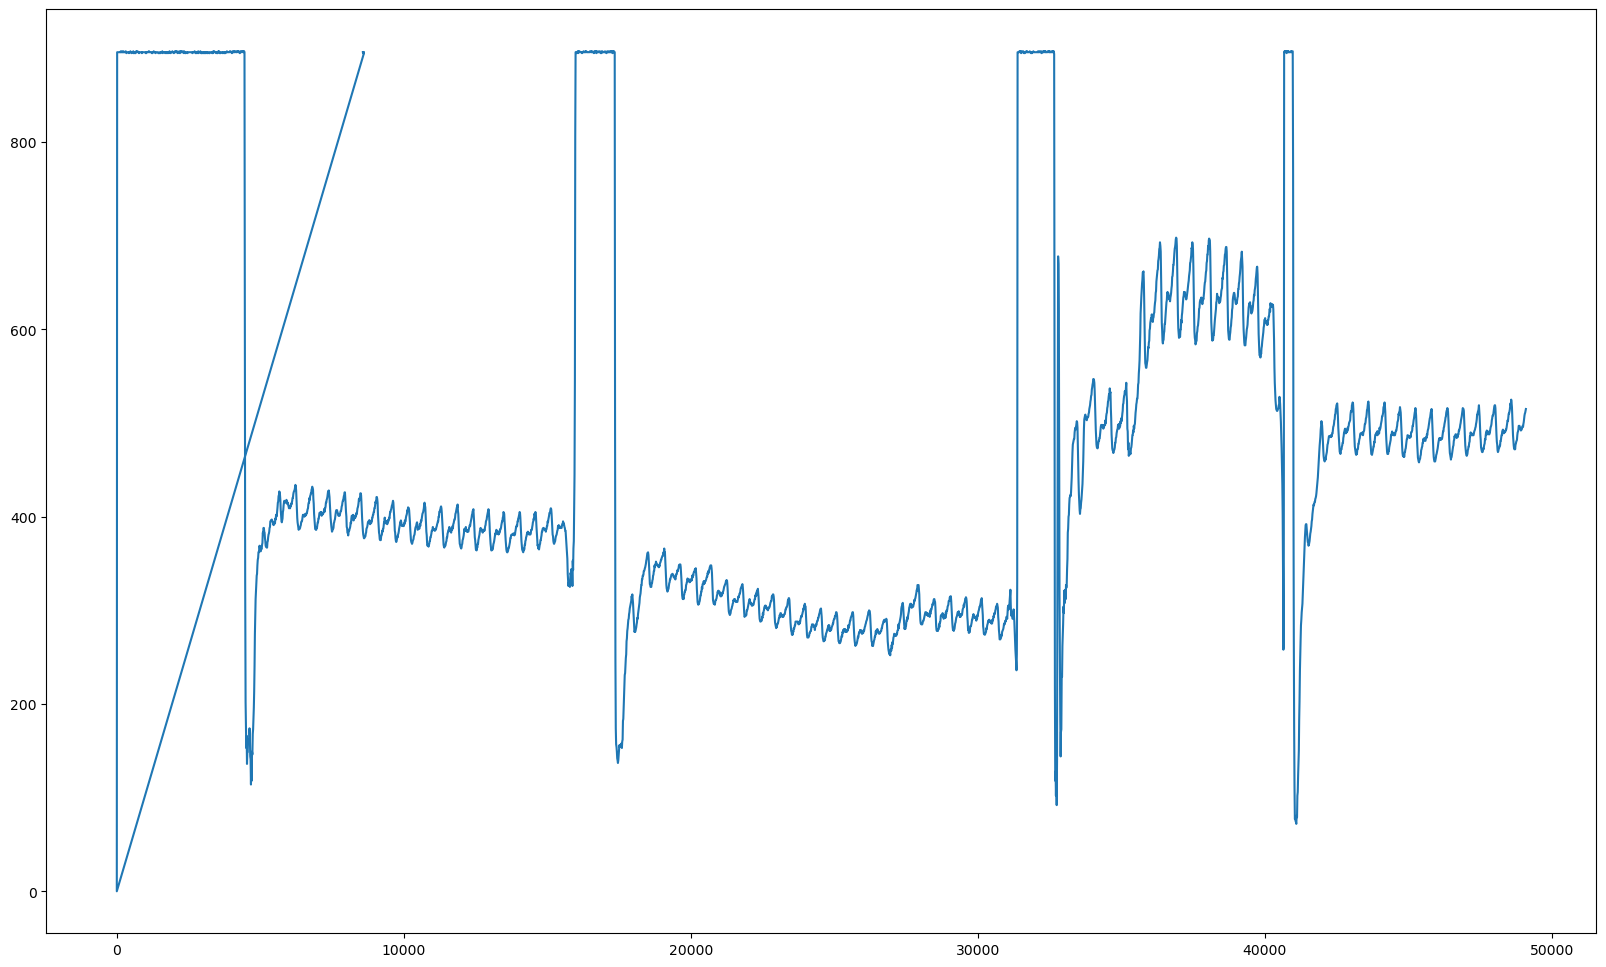

In [12]:
plt.figure(figsize=(20, 12))
plt.plot(samples[:, 0], samples[:, 1])

In [13]:
inverted = True

In [14]:
def clean_up(t, v):
    filtered_idxes = []
    for i in range(40, t.shape[0]):
        if t[i]!=t[i-1]:
            filtered_idxes.append(i)
    return t[filtered_idxes], v[filtered_idxes]

In [15]:
t, v = clean_up(samples[:,0], samples[:,1])
if inverted:
    v = 1023 - v
print(t,v)

[  167.   180.   193. ... 49064. 49077. 49089.] [127. 127. 126. ... 512. 510. 508.]


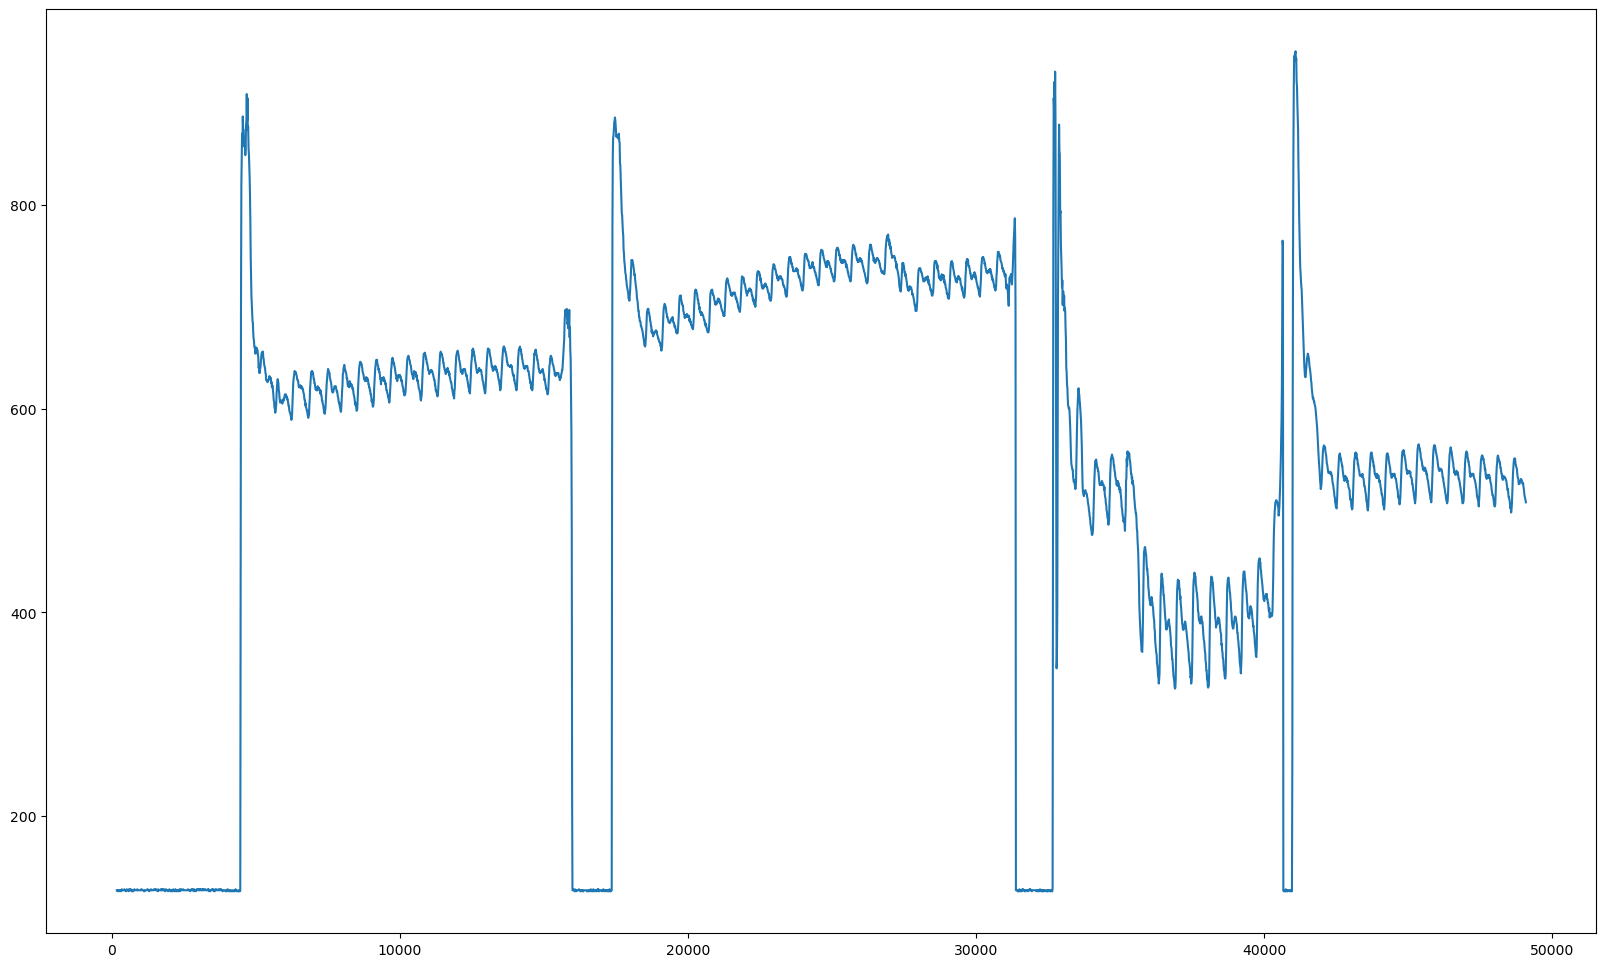

In [16]:
plt.figure(figsize=(20, 12))
plt.plot(t, v)

In [17]:
def dc_filter(vs, alpha = 0.96):
    dcs = []
    v_filtered = []
    w_last = 0
    for v in vs:
        w = v + alpha * w_last
        dcs.append(w*(1-alpha))
        v_filtered.append(w-w_last)
        w_last = w
        
    return np.array(v_filtered), np.array(dcs)

In [18]:
v_hpf, dcs = dc_filter(v)

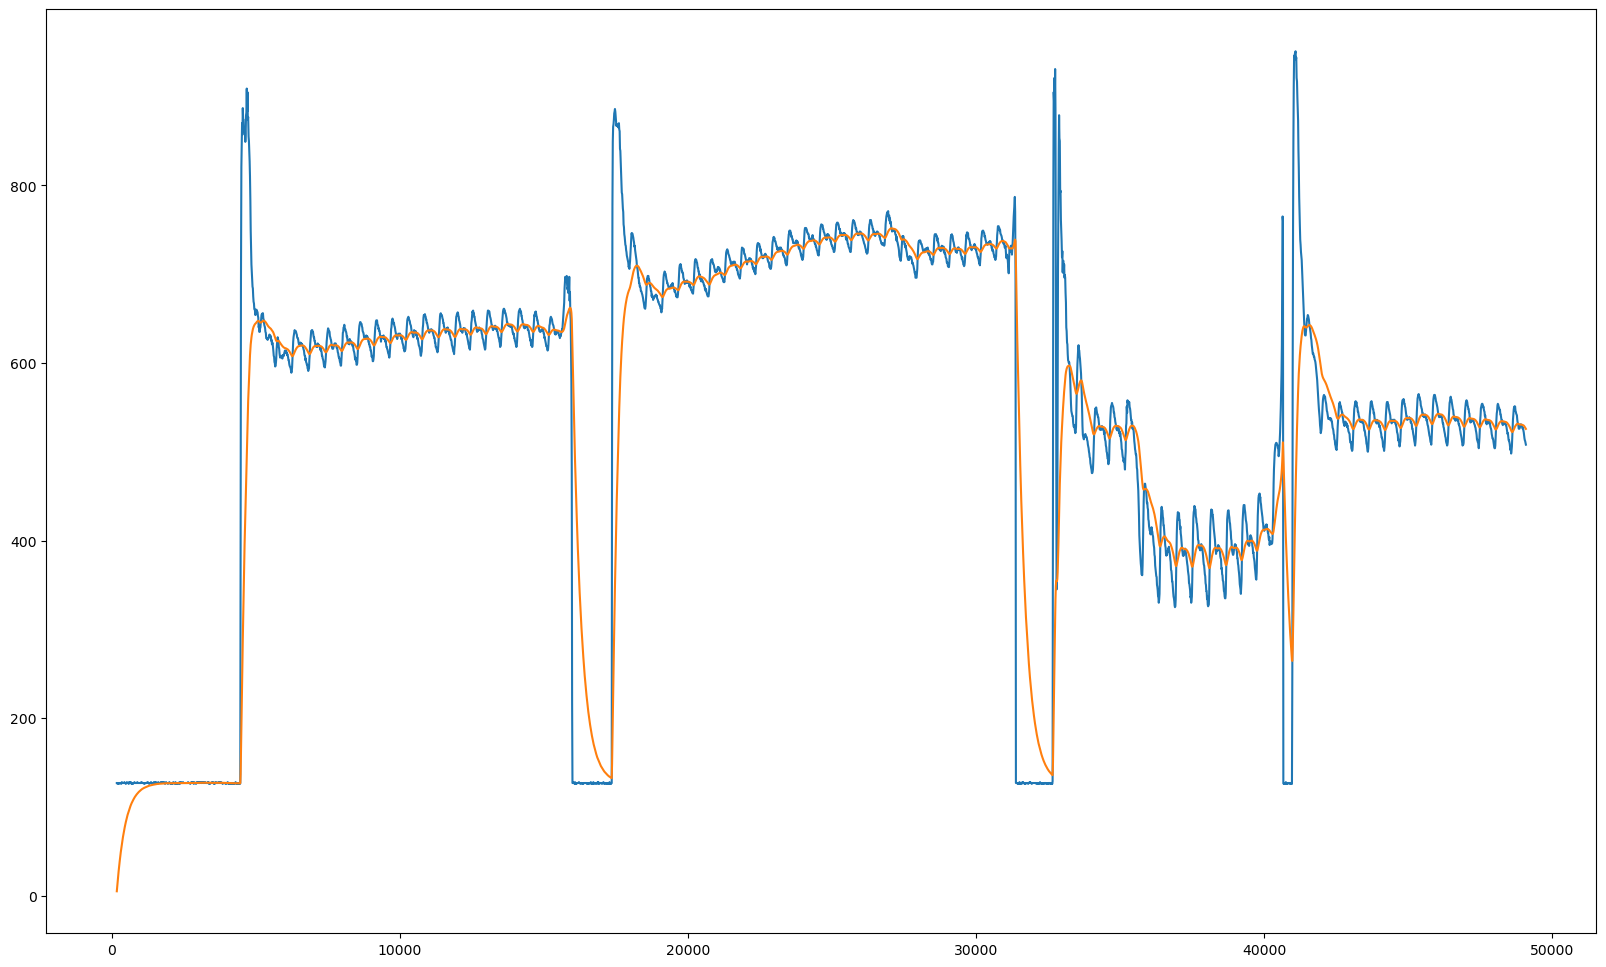

In [19]:
plt.figure(figsize=(20, 12))
plt.plot(t, v)
plt.plot(t, dcs)
plt.show()

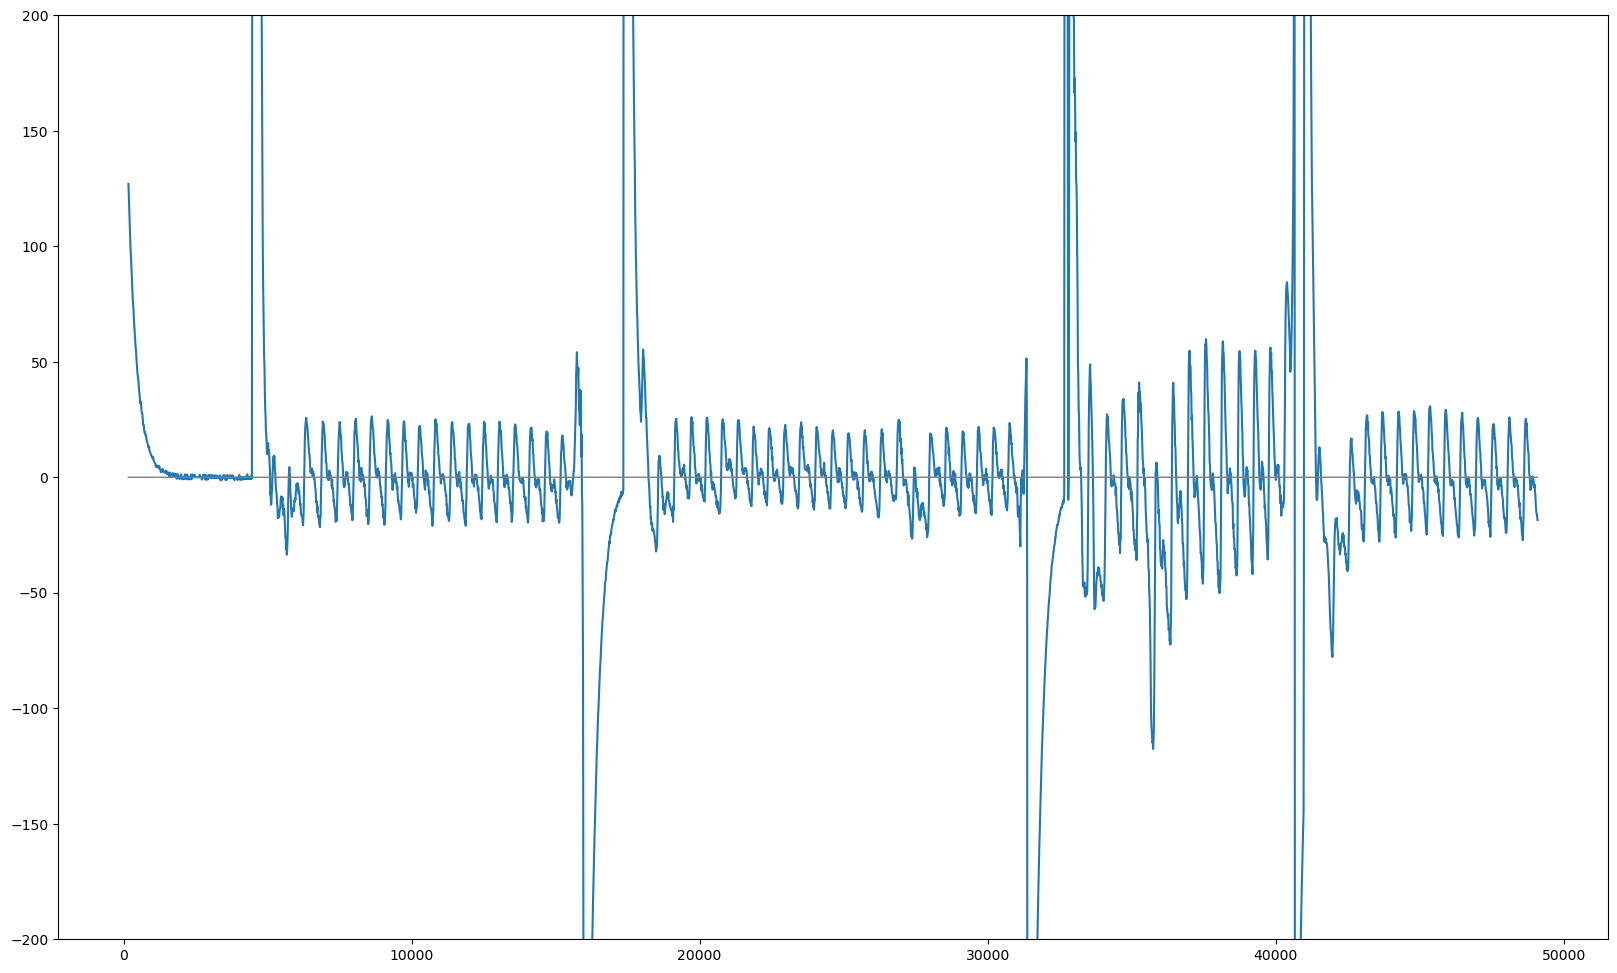

In [37]:
plt.figure(figsize=(20, 12))
plt.plot(t, v_hpf)
plt.plot(t, np.zeros_like(t), linewidth=1, color='grey')
plt.ylim(-200, 200)
# plt.ylim(-70, 70)
# plt.xlim(8000, 10000)
plt.show()


In [197]:
region0 = (8000, 15000)
region1 = (20000, 26000)
region2 = (33000, 40000)
region3 = (44000, 48000)

### Adding bias/distortions: Skip this if you don't want to simulate noise/bias/distortions

In [28]:
v_hpf = v_hpf + 15

In [536]:
t = t*1.5

In [396]:
t = t/2

In [527]:
v_hpf = v_hpf/1.6

In [27]:
noise_scale = 15
v_hpf = v_hpf + np.random.uniform(-noise_scale, noise_scale, t.shape[0])

In [560]:
v_hpf = butterworth_lpf(v_hpf, 5, 80)

In [33]:
# Reset the signal running this block
t, _ = clean_up(samples[:,0], samples[:,1])
v_hpf, dcs = dc_filter(v)

### Beat Detection

In [198]:
SAMPLE_RATE = 80
SAMPLE_PERIOD = 1000/SAMPLE_RATE
STATE_WAITING = 0
STATE_UPWARD = 1
STATE_PENDING_DETECTION = 2
STATE_MASKED = 3
palette = ['grey', 'orange', 'green', 'black']

class beatDetector:
    def __init__(self, min_threshold = 4, max_threshold = 64, v_max_cap=80, upward_slop_thres = 0.06, slope_alpha=0.6, period_alpha = 0.6, 
                 no_beat_timeout = 2000, mask_delay = 200, dropping_deadzone = 5, thres_drop_factor = 1.2, thres_decay_factor = 0.98):

        self.MIN_THRES = min_threshold
        self.MAX_THRES = min(max_threshold, v_max_cap)
        self.V_MAX_CAP = v_max_cap
        self.UPWARD_SLOP_THRES = upward_slop_thres
        self.SLOPE_ALPHA = slope_alpha
        self.PERIOD_ALPHA =  period_alpha
        self.NO_BEAT_TIMEOUT = no_beat_timeout
        self.MASK_DELAY = mask_delay
        self.DROPPING_DEADZONE = dropping_deadzone
        self.THRES_DROP_FACTOR = thres_drop_factor
        self.THRES_DECAY_FACTOR = thres_decay_factor
        
        self.slope = 0
        self.v_last = 0
        self.t_last = 0
        self.threshold = min_threshold
        self.state = STATE_WAITING
        self.period = 0
        self.t_last_peak = 0
        self.v_last_peak = -self.V_MAX_CAP
        

    def step(self, t, v):
        peak_detected = False
        
        v = min(v, self.V_MAX_CAP)
        current_slope = (v-self.v_last)/(t-self.t_last)
        slope_alpha_corrected = self.SLOPE_ALPHA*(t-self.t_last)/SAMPLE_PERIOD
        self.slope = slope_alpha_corrected*current_slope + (1-slope_alpha_corrected)*self.slope
        # print(self.slope)
        
        capped = False
        if (v >= self.V_MAX_CAP-0.5) and (self.v_last >= self.V_MAX_CAP-0.5):
            # print("\ncapped", self.slope, v, self.v_last, current_slope, t, self.t_last, slope_alpha_corrected, "state =", self.state)
            self.state = STATE_WAITING
            # print("capped", self.slope, v, self.v_last, current_slope, t, self.t_last, slope_alpha_corrected, "state =", self.state)
            self.threshold = self.MAX_THRES
            capped = True
            # print()
            
        if (self.state == STATE_WAITING):
            
            if (v > self.threshold) and (self.slope > self.UPWARD_SLOP_THRES) and (not capped):
                self.threshold = min(v, self.MAX_THRES)
                self.state = STATE_UPWARD
                # print(t, "to upward")

            if (t - self.t_last_peak > self.NO_BEAT_TIMEOUT):
                self.v_last_peak = -self.V_MAX_CAP
                self.period = 0

            self.decrease_threshold(t)
                
        elif (self.state == STATE_UPWARD):
            if (v < self.threshold):
                self.state = STATE_PENDING_DETECTION
                # print(t, "detected \n")
            else:
                self.threshold = min(max(v,self.threshold) , self.MAX_THRES)

        elif (self.state == STATE_PENDING_DETECTION):
            if (v < self.threshold - self.DROPPING_DEADZONE):
                peak_detected = True
                self.state = STATE_MASKED

                if (self.v_last_peak > -self.V_MAX_CAP):
                    delta = t - self.t_last_peak
                    period_alpha_corrected = self.PERIOD_ALPHA*(t-self.t_last)/SAMPLE_PERIOD
                    self.period = delta*period_alpha_corrected + (1-period_alpha_corrected)*self.period

                
                self.v_last_peak = self.threshold
                self.t_last_peak = t
            else:
                self.state = STATE_UPWARD
        
        elif (self.state == STATE_MASKED):
            if (t - self.t_last_peak > self.MASK_DELAY):
                self.state = STATE_WAITING
            self.decrease_threshold(t)

        # if (capped):
        #     print("final state =", self.state)
                   

        self.t_last = t
        self.v_last = v

        return peak_detected, self.threshold, self.state, self.period

    def decrease_threshold(self, t):
        
        # print("before: ", self.threshold)
        if (self.period > 0) and (self.v_last_peak > 0):
            
            self.threshold -= self.v_last_peak * self.THRES_DROP_FACTOR  * (t-self.t_last) / self.period
            # print("(self.period > 0) and (self.v_last_peak > 0):", self.v_last_peak * self.THRES_DROP_FACTOR  * (t-self.t_last) / self.period)
        else:
            self.threshold *= self.THRES_DECAY_FACTOR
            
        # print(self.threshold, self.MIN_THRES)
        self.threshold = max(self.threshold, self.MIN_THRES)
        

In [199]:
def detect_beat(t, v_hpf):
    detector = beatDetector()
    beats_t = []
    beats_v = []
    thresholds = []
    states = []
    periods = []
    for idx in range(t.shape[0]):
        t_sample = t[idx]
        v_sample = v_hpf[idx]
        peak_detected, threshold, state, period = detector.step(t_sample, v_sample)
        thresholds.append(threshold)
        states.append(state)
        if peak_detected:
            beats_t.append(t_sample)
            beats_v.append(detector.v_last_peak)
            periods.append(period)

    return (beats_t, beats_v, thresholds, states, periods)

red_results = detect_beat(t, v_hpf)
# print(states)

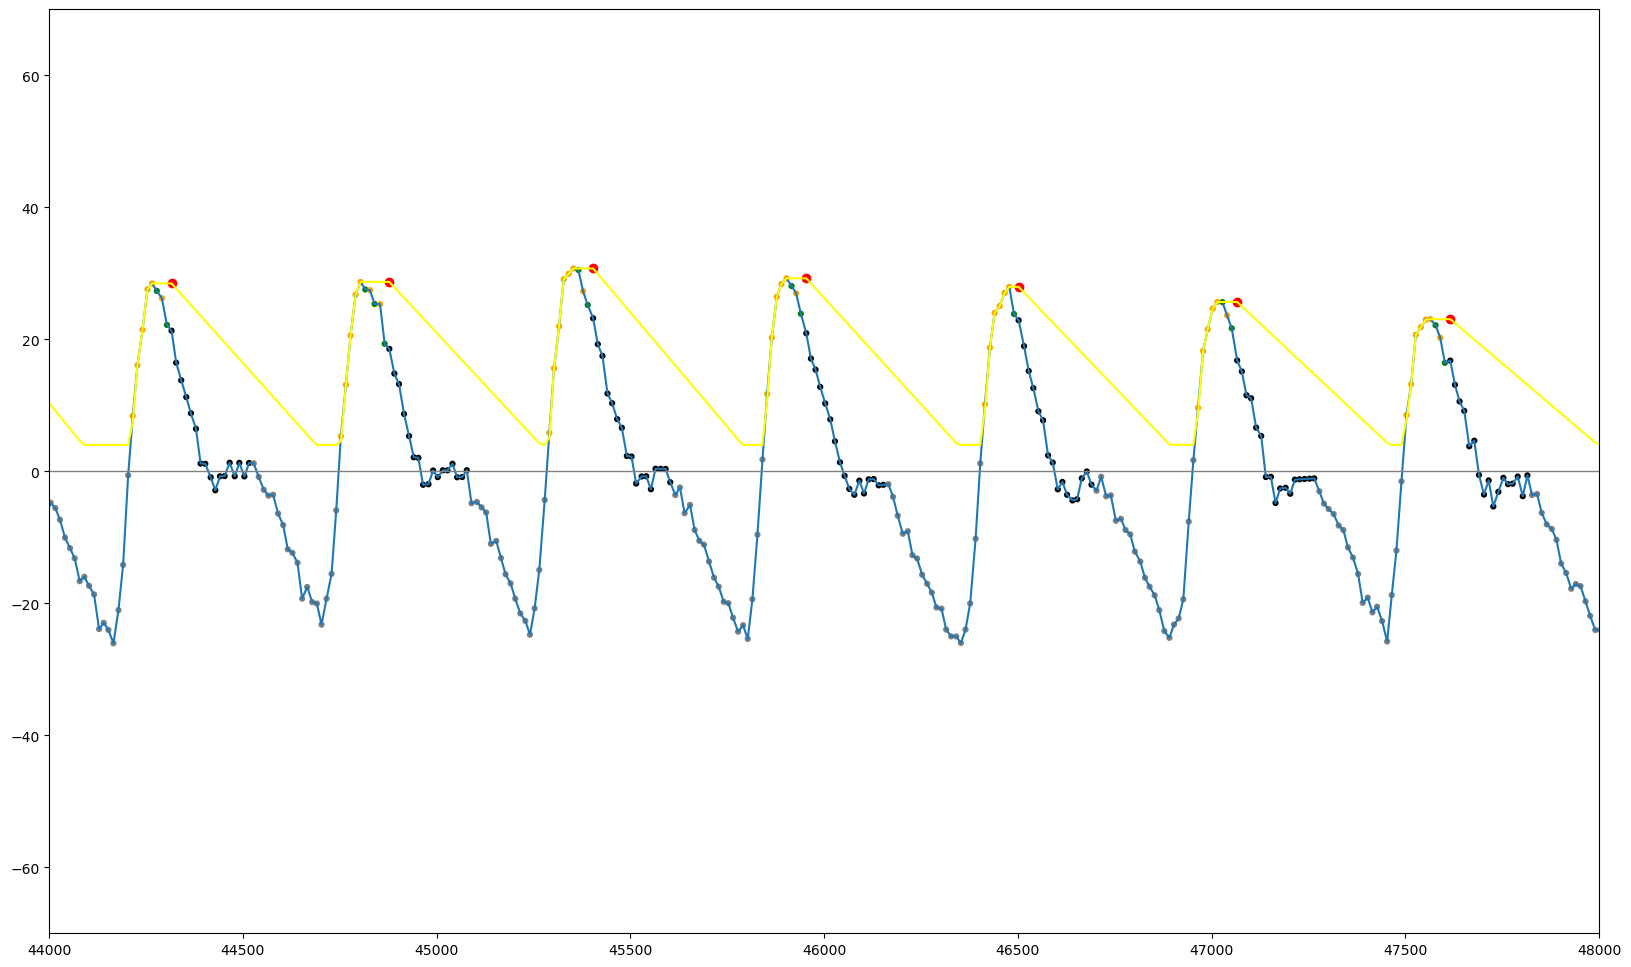

In [200]:
# plot beat detection result for RED LED
def plot_result(args, xlims = None):
    (beats_t, beats_v, thresholds, states, periods) = args
    plt.figure(figsize=(20, 12))
    plt.plot(t, v_hpf)
    plt.plot(t, thresholds, color='yellow')
    plt.scatter(beats_t, beats_v, color='red')
    plt.plot(t, np.zeros(t.shape[0]), linewidth=1, color='grey')
    state_colors = [palette[i] for i in states]
    plt.scatter(t, v_hpf, c=state_colors, s=12)
    plt.ylim(-70, 70)
    if xlims is not None:
        plt.xlim(xlims)
    # plt.xlim(10000, 20000)
    # plt.xlim(6000, 10000)
    plt.show()
    
# plot_result(red_results, (25000, 40000))
plot_result(red_results, region3)

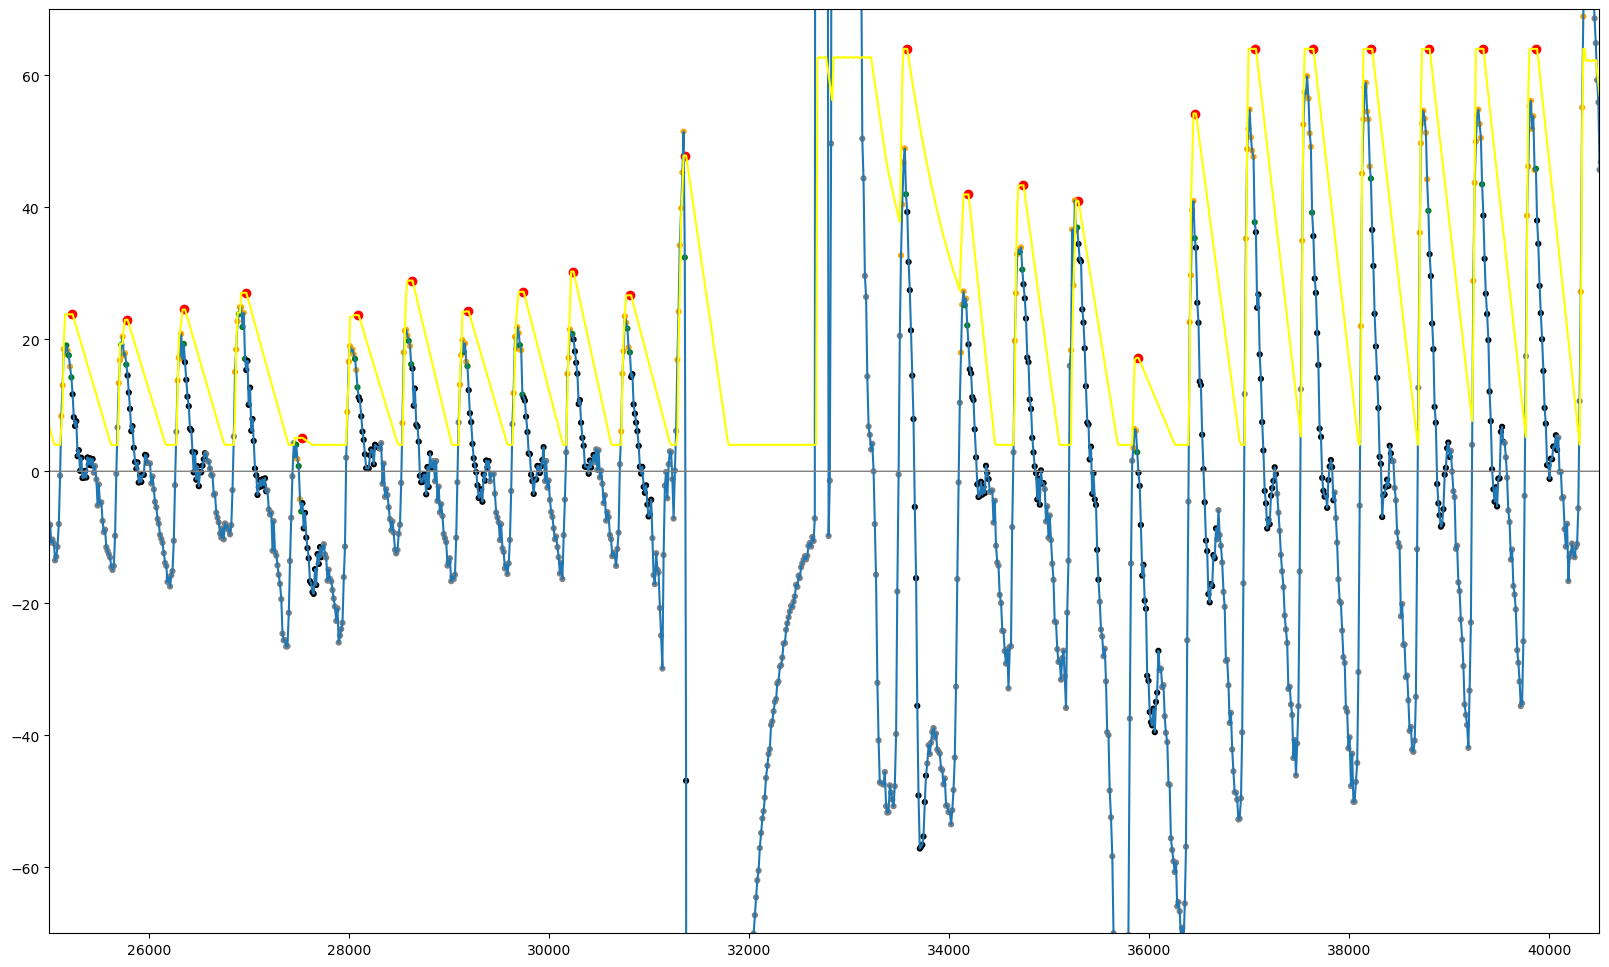

In [201]:
# plot beat detection result for IR LED
t_ir, v_ir = clean_up(samples[:,2], samples[:,3])
if inverted:
    v_ir = 1023 - v_ir
v_hpf_ir, dcs_ir = dc_filter(v_ir)

ir_results = detect_beat(t_ir, v_hpf_ir)
plot_result(ir_results, (25000, 40500))

### Calculate HPM

In [202]:
def get_HPM(periods):
    HPMs = []
    for period in periods:
        HPMs.append(1000*60/period if period > 200 else -1)
    
    for i, hpm in enumerate(HPMs[-2::-1]):
        if hpm < 0:
            hpm = HPMs[i+1]

    return HPMs

hpms_red = get_HPM(red_results[4])   

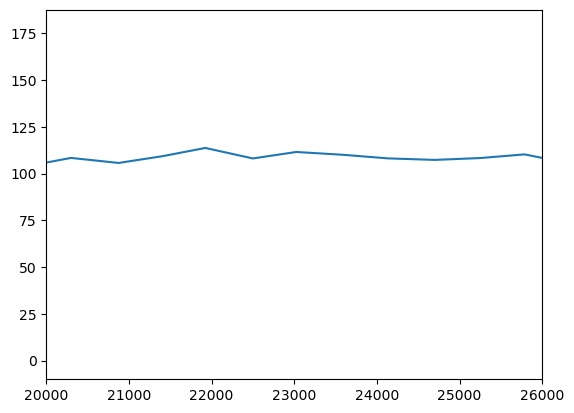

In [209]:
plt.xlim(region1)
plt.plot(red_results[0], hpms_red)

### Calculate SpO2

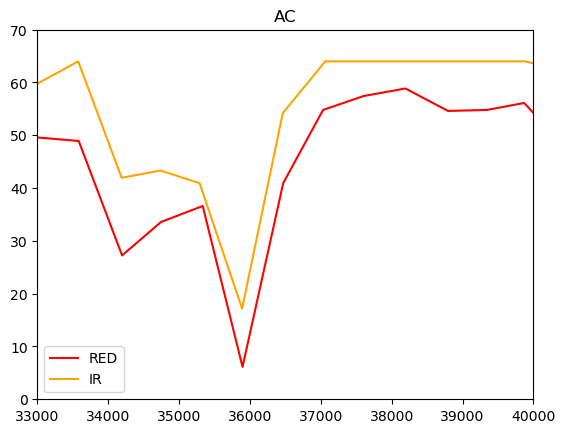

In [204]:
# AC voltage
plt.plot(red_results[0], red_results[1], color='red', label="RED")
plt.plot(ir_results[0], ir_results[1], color='orange', label="IR")
plt.xlim(region2)
plt.ylim(0, 70)
plt.title("AC")
plt.legend()
plt.show()

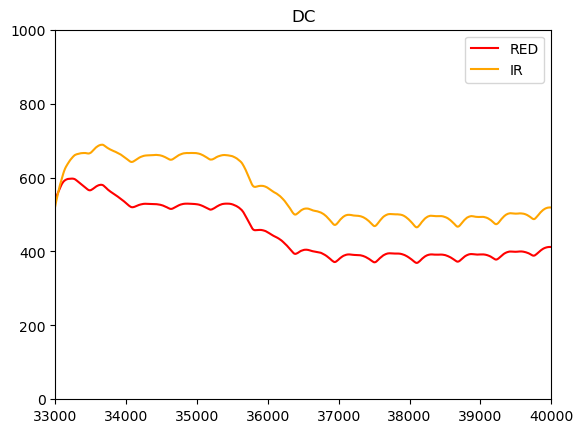

In [205]:
# DC voltage
plt.plot(t, dcs, color='red', label="RED")
plt.plot(t_ir, dcs_ir, color='orange', label="IR")
plt.xlim(region2)
plt.ylim(0, 1000)
plt.title("DC")
plt.legend()
plt.show()

In [206]:
def calculate_spo2(AC1, DC1, AC2, DC2):
    a = -3.3
    b = -21.1
    c = 109.6
    
    R = (AC1/DC1)/(AC2/DC2);
    SpO2 = (a*R*R + b*R + c);

    return SpO2
    
t_raw = samples[:,0]
# Need to interpolate by time to make timestamps of ac and dc consistent
spo2 = calculate_spo2(np.interp(t_raw, red_results[0], red_results[1]), np.interp(t_raw, t, dcs), 
                      np.interp(t_raw, ir_results[0], ir_results[1]), np.interp(t_raw, t_ir, dcs_ir))

(44000.0, 48000.0)

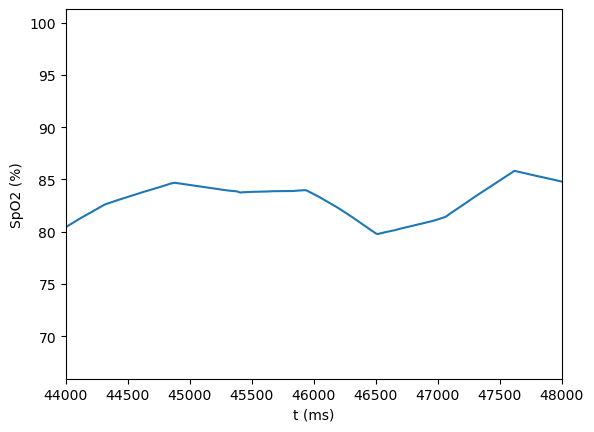

In [216]:
# Plot SpO2
plt.plot(t_raw, spo2)
plt.xlabel("t (ms)")
plt.ylabel("SpO2 (%)")
plt.xlim(region3)